In [1]:
# This script is used to calculate general crop phenology
# Use central US as an example and obtain Fig. 3a
# Codes can be used at grid-level as well 

In [2]:
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
from scipy.optimize import curve_fit

C:\Users\jiang\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#grid 1 DEG
y1d=np.arange(70,-60.1,-1)
x1d=np.arange(-170,180.1,1)
lon1s,lat1s=np.meshgrid(x1d, y1d)

In [5]:
#2 DEG, cropland mask
imai0=np.load('/change to your path/imai0_full.npy',allow_pickle=True)
#Windows directory: 'C:\\change to your path\\imai0_full.npy'
y3d=np.arange(70,-60.1,-2.)
x3d=np.arange(-170,180.1,2.)
lon3s,lat3s=np.meshgrid(x3d, y3d)
imai_2degf=np.zeros((66,176))*np.nan
for y in range(66):
    for x in range(176):
        al=[imai0[0,y,x],imai0[1,y,x],imai0[2,y,x],imai0[3,y,x],imai0[4,y,x]]
        if np.count_nonzero(np.array(al)>0)>0:
            imai_2degf[y,x]=np.nanmax(al)

In [6]:
#crop calendar data mask
wcu=xr.open_dataset('/change to your path/Wheat.crop.calendar.nc')
loncs,latcs=np.meshgrid(wcu.longitude[19::], wcu.latitude[39:300])#GCE
long,latg=np.meshgrid(wcu.longitude, wcu.latitude)#CCD
imog_nacf=np.load('/change to your path/cecl_gs_0.5_v3.npy',allow_pickle=True)         
#2deg
y1d=np.arange(70,-60.1,-2)
x1d=np.arange(-170,180.1,2)
lon2s,lat2s=np.meshgrid(x1d, y1d)
imog_nac2=np.zeros((2,66,176))*np.nan
imog_nac2[0,:,:] = griddata((loncs.ravel(),latcs.ravel()), imog_nacf[0,:,:].ravel(),(lon2s, lat2s) , method='nearest')   
imog_nac2[1,:,:] = griddata((loncs.ravel(),latcs.ravel()), imog_nacf[1,:,:].ravel(),(lon2s, lat2s) , method='nearest') 

In [7]:
#2002-2022 NIRv datasets###############################################################
nirvf=np.load('/change to your path/nir_full_1deg_qcl.npy',allow_pickle=True)
nirvf5=np.zeros((21,73,66,176))*np.nan
for yr in range(21):
    for pdt in range(73):
        nirvf5[yr,pdt,:,:] = griddata((lon1s[0:130,0:350].ravel(),lat1s[0:130,0:350].ravel()), nirvf[yr,pdt,::-1,:].ravel(),(lon3s, lat3s) , method='nearest')   
#get rid of non crop & -1 grids
crop_m3=np.where(imai_2degf<2)#better rerun the array readin code
nirvf_m5=np.ones((21,73,66,176))*np.nan
for yr in range(21):
    for pdt in range(73):
        mk4=np.where(nirvf5[yr,pdt,:,:]<0)
        i3=nirvf5[yr,pdt,:,:]
        i3[mk4]=np.nan
        i3[crop_m3]=np.nan
        nirvf_m5[yr,pdt,:,:]=i3

In [8]:
#quality control for grid level use
#percentage of data availability during the main growing season
nirv_c22=np.ones((66,176))*np.nan
for y in range(66):
    for x in range(176):
        if np.isnan(np.nanmean(nirvf_m5[yr,:,y,x]))==False and imai_2degf[y,x]>=2:
            nm2=np.nanmean(nirvf_m5[1:18,:,y,x],axis=0)
            sog_na=imog_nac2[0,y,x]
            eog_na=imog_nac2[1,y,x]
            if np.isnan(sog_na)==False and np.isnan(eog_na)==False:
                sogr_na=int(round(sog_na)/5.)#if %5==0, then need to -1
                eogr_na=int(round(eog_na)/5.)
                if round(sog_na)%5==0:
                    sogr_na=sogr_na-1
                if round(eog_na)%5==0:
                    eogr_na=eogr_na-1
                if sogr_na<=eogr_na:
                    nirv_c22[y,x]=np.count_nonzero(np.isnan(nm2[sogr_na:eogr_na+1]))/(eogr_na+1-sogr_na)*100. 
                if sogr_na>eogr_na:
                    nirv_c22[y,x]=(np.count_nonzero(np.isnan(nm2[sogr_na:73]))+np.count_nonzero(np.isnan(nm2[0:eogr_na+1])))/(73-sogr_na+eogr_na+1)*100.   

C:\Users\jiang\AppData\Local\Temp\ipykernel_12316\4258119090.py:6: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(nirvf_m5[yr,:,y,x]))==False and imai_2degf[y,x]>=2:
C:\Users\jiang\AppData\Local\Temp\ipykernel_12316\4258119090.py:7: RuntimeWarning: Mean of empty slice
  nm2=np.nanmean(nirvf_m5[1:18,:,y,x],axis=0)


In [9]:
#subplot1: nmark out################
#averaged NIRv curve over NA region
x1=np.arange(1,74)
na_shc=np.nanmean(np.nanmean(np.nanmean(nirvf_m5[1:20,:,12:21,35:46],axis=0),axis=1),axis=1)
#beck_model fitting
sog_nac=np.nanmean(imog_nac2[0,12:21,35:46])
eog_nac=np.nanmean(imog_nac2[1,12:21,35:46])
#prepare for the fitting 
sogr_nac=int(round(sog_nac)/5.)#if %5==0, then need to -1
eogr_nac=int(round(eog_nac)/5.)
nbase=np.nanmean(np.append(na_shc[0:sogr_nac],na_shc[eogr_nac+1::]))
nmax=np.nanmax(na_shc[sogr_nac:eogr_nac+1])
def beck_model_na(x1,a,b,c,d):
    return nbase+(nmax-nbase)*(1/(1+np.exp((-1)*a*(x1-b)))+1/(1+np.exp(c*(x1-d)))-1)
#tune up maxfev for sufficient iteration
popt_na, pcov_na =curve_fit(beck_model_na,x1,na_shc+np.random.normal(0, nbase*0.01, x1.shape),maxfev=100000)

#note, curve_fit can be run a few more times if the fitting was not obtained

C:\Users\jiang\AppData\Local\Temp\ipykernel_12316\3672179415.py:4: RuntimeWarning: Mean of empty slice
  na_shc=np.nanmean(np.nanmean(np.nanmean(nirvf_m5[1:20,:,12:21,35:46],axis=0),axis=1),axis=1)
C:\Users\jiang\AppData\Local\Temp\ipykernel_12316\3672179415.py:14: RuntimeWarning: overflow encountered in exp
  return nbase+(nmax-nbase)*(1/(1+np.exp((-1)*a*(x1-b)))+1/(1+np.exp(c*(x1-d)))-1)


In [10]:
#check the 2nd derivatives
dy1s=np.gradient(beck_model_na(x1, *popt_na),x1)
dy2s=np.gradient(dy1s,x1)
dy3s=np.gradient(dy2s,x1)

In [11]:
#find the flection points
minu=popt_na[1]
maxd=popt_na[3]

max1=np.where(dy3s[0:int(minu+1)]==np.nanmax(dy3s[0:int(minu+1)]))
na_u1=max1[0][0]+1#u1--x1
maxrl=x1[np.where(na_shc==np.nanmax(na_shc))[0][0]]
max2=np.where(dy3s[int(minu):maxrl+1]==np.nanmax(dy3s[int(minu):maxrl+1]))
na_u2=max2[0][0]+int(minu)+1#u2
maxd=popt_na[3]#d1
min1=np.where(dy3s[max2[0][0]+int(minu):int(maxd+1)]==np.nanmin(dy3s[max2[0][0]+int(minu):int(maxd+1)]))
na_d1=min1[0][0]+max2[0][0]+int(minu)+1
min2=np.where(dy3s[int(maxd)::]==np.nanmin(dy3s[int(maxd)::]))
na_d2=min2[0][0]+int(maxd)+1

Text(0.0, 1.0, 'NA example')

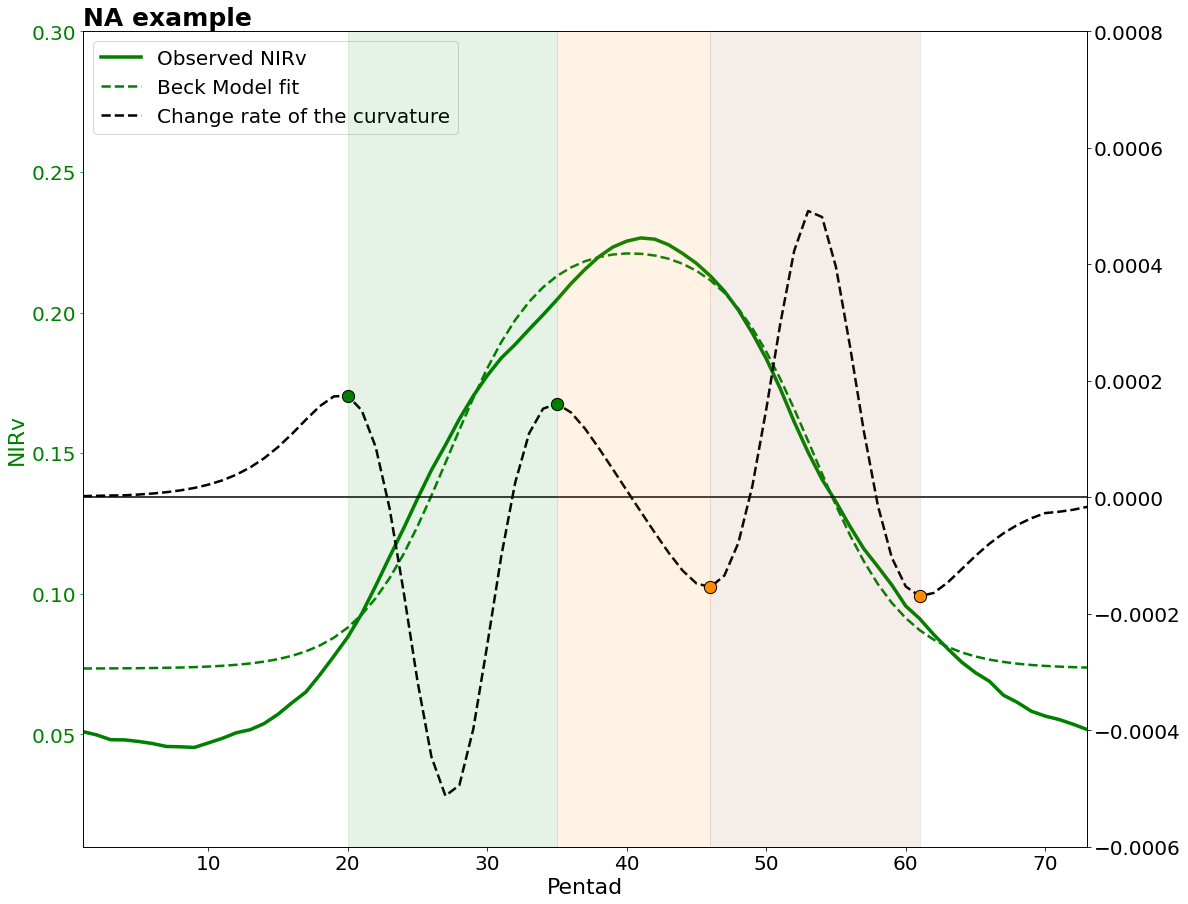

In [12]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(18,15))
ax1 = fig.add_subplot(111)
#ax1 = plt.subplot(321)
p1=ax1.plot(x1,na_shc, 'g',linewidth=3.5,label='Observed NIRv')
p2=ax1.plot(x1, beck_model_na(x1, *popt_na), 'g--',linewidth=2.5,label='Beck Model Fit')
ax1.set_ylim(0.01,0.3)
ax12=ax1.twinx()
p3=ax12.plot(x1,dy3s, 'k--',linewidth=2.5,label='Change rate of the curvature',zorder=1)
p4=ax12.plot(x1,np.zeros(73), 'k',linewidth=1.5,zorder=1)
ax12.set_ylim(-0.0006,0.0008)
ax12.set_xlim(1,73)
ax1.set_xlim(1,73)
ax12.scatter(na_u1,dy3s[na_u1-1],s=150,facecolors='green', edgecolors='black',zorder=2)
ax12.scatter(na_u2,dy3s[na_u2-1],s=150,facecolors='green', edgecolors='black',zorder=2)
ax12.scatter(na_d1,dy3s[na_d1-1],s=150,facecolors='darkorange', edgecolors='black',zorder=2)
ax12.scatter(na_d2,dy3s[na_d2-1],s=150,facecolors='darkorange', edgecolors='black',zorder=2)
ax1.legend((p1[0],p2[0],p3[0]),('Observed NIRv','Beck Model fit','Change rate of the curvature'),loc='upper left',ncol=1,prop={'size': 20})
ax1.tick_params(labelsize=20)
ax1.tick_params('y',colors='g')
ax12.tick_params(labelsize=20)
ax12.fill_between(np.linspace(na_u1,na_u2,10),np.ones(10)*-0.0008,np.ones(10)*0.0008,color='green',alpha=0.1)
ax12.fill_between(np.linspace(na_u2,na_d1,10),np.ones(10)*-0.0008,np.ones(10)*0.0008,color='darkorange',alpha=0.1)
ax12.fill_between(np.linspace(na_d1,na_d2,10),np.ones(10)*-0.0008,np.ones(10)*0.0008,color='sienna',alpha=0.1)
ax1.set_xlabel("Pentad",fontsize=22)
ax1.set_ylabel("NIRv",color='g',fontsize=22)
ax1.set_title('NA example', loc='left',fontsize=25,fontweight='bold')